In [1]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header = None)
df_wine.columns = ["class","alcohol", "malic_acid", "ash", "alcalinity_of_ash", "magnesium","total_phenols", "flavanoids", "nonflavanoid_phenols", "proanthocyanins","color_intensity", "hue", "od280_od315", "proline"]

from sklearn.model_selection import train_test_split

X = df_wine.iloc[:,1:].values
Y = df_wine.iloc[:,0].values

x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size= 0.3, stratify= Y)

from sklearn.preprocessing import StandardScaler

SSC =  StandardScaler()
x_train_std = SSC.fit_transform(x_train)
x_test_std =  SSC.transform(x_test)


# Computing D dimensional mean

Note: Each mean vector, mi, stores the mean feature value Um , with respect to the examples of class i
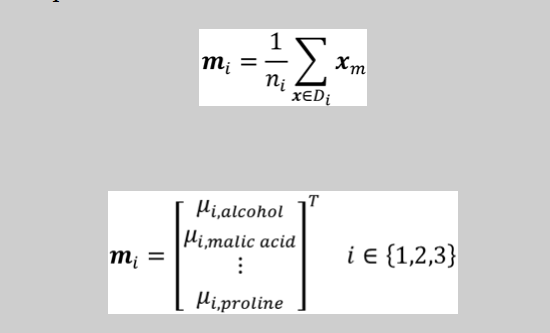

These mean vectors can be computed by the following code, where we compute one mean vector for each of the three labels:
Note:
- Within-class scatter: how spread out samples are around their class mean.
- Between-class scatter: how far apart the class means are from each other..


In [2]:
import numpy as np

np.set_printoptions(precision = 4) # DEcimal places
mean_vecs = []

for label in range(1,4):
    mean_vecs.append(np.mean(x_train_std[label == y_train], axis = 0))

    print(f"the Mv {label} : {mean_vecs[label - 1]}\n")
    # It took the values belongingto current class
    
    


the Mv 1 : [ 0.9209 -0.2927  0.3551 -0.7384  0.473   0.932   0.9715 -0.6007  0.6028
  0.2148  0.4289  0.8185  1.1664]

the Mv 2 : [-0.9312 -0.3311 -0.4528  0.2645 -0.3253 -0.155   0.0104  0.0672 -0.008
 -0.8594  0.4494  0.1788 -0.6992]

the Mv 3 : [ 0.2668  0.8652  0.2449  0.5165 -0.0948 -0.9231 -1.2228  0.6445 -0.7367
  1.0352 -1.2139 -1.2878 -0.3897]



Note: 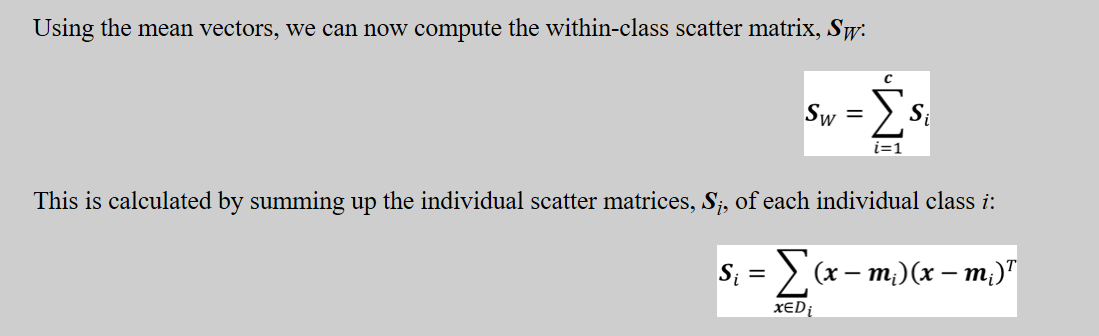

In [3]:
d =  13
S_W = np.zeros((d,d))

for labels, mv in zip(range(1,4),mean_vecs):
    class_scatter = np.zeros((d,d))
    for row in x_train_std[y_train == labels]:
        row,mv = row.reshape(d,1),mv.reshape(d,1)
        class_scatter += (row - mv) * (row - mv).T

    S_W += class_scatter

# Lets take a look if the class is uniform

print(f"The class label  is{np.bincount(y_train)[1:]}")

# Ain`t uniform



The class label  is[41 50 33]


In the previous cell we saw the class is not uniform 1: 41, 2:50 ..
Therefore to avid bias we scale each class scatter Si by dividing the number of sample in that class(ni) [[Coverancce matrix]]
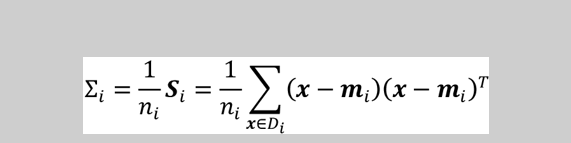

In [4]:
d = 13
S_w = np.zeros((d,d))
for label, mv in zip(range(1,4), mean_vecs):
    class_scatter = np.cov(x_train_std[y_train == label].T)
    S_w += class_scatter
    

Computing In between Scatter matrix 
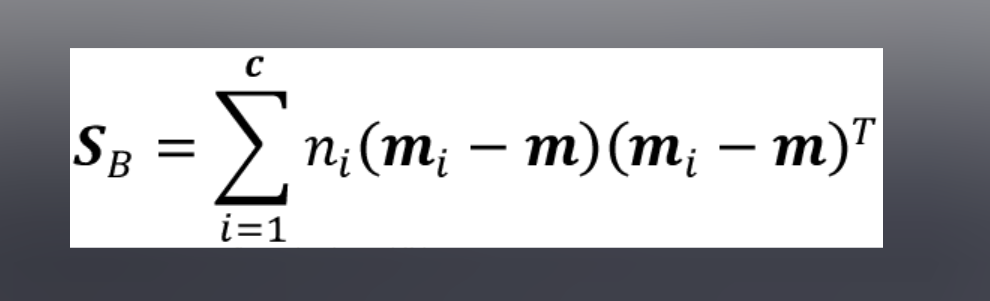

In [5]:
mean_overall = np.mean(x_train_std,axis = 0)

mean_overall = mean_overall.reshape(d,1)
S_B = np.zeros((13,13))

for i, mv in enumerate(mean_vecs):
    n = x_train_std[i+1,:].shape[0]
    #counting number of row / class
    mv = mv.reshape(d,1)
    S_B += n*(mv-mean_overall).dot((mv-mean_overall).T)

print(f'Between class is {S_B.shape[0]} * {S_B.shape[1]} ')


Between class is 13 * 13 


# SELECTING LINEAR DISCRIMINANT FOR THE NEW FEATURE 
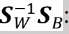

129.3437823862415
49.27209641993651
2.1901330069968754e-14
1.2936874746663807e-14
1.2936874746663807e-14
7.105427357601002e-15
7.079310977247416e-15
7.079310977247416e-15
2.997468973816067e-15
2.997468973816067e-15
1.913751942193498e-15
1.913751942193498e-15
1.2994851283618785e-15


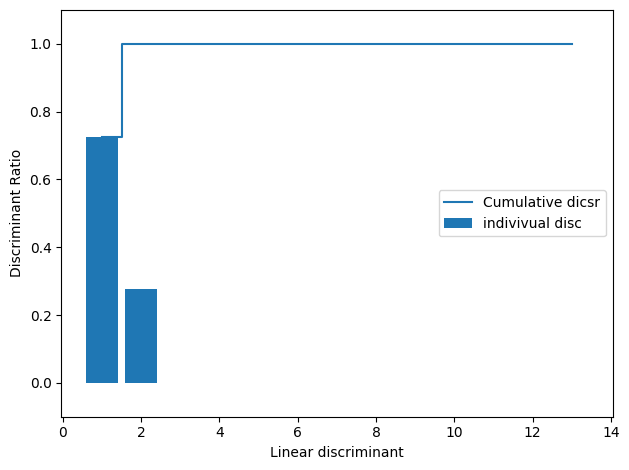

In [6]:
import matplotlib.pyplot as plt

eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_w).dot(S_B))
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
for eigen_val in eigen_pairs:
    print(eigen_val[0])

tot = sum(eigen_vals.real)

discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]

cum_disc = np.cumsum(discr)

plt.bar(range(1,14), discr, align = 'center', label = 'indivivual disc')
plt.step(range(1,14), cum_disc, where  = 'mid', label = "Cumulative dicsr")

plt.ylabel("Discriminant Ratio")
plt.xlabel("Linear discriminant")
plt.ylim([-0.1,1.1])
plt.legend(loc = "best")
plt.tight_layout()
plt.show()


# Projecting examples onto the new feature space

Matrux iz[[-0.1322  0.4555]
 [ 0.0845  0.0751]
 [-0.125   0.4532]
 [ 0.275  -0.3972]
 [ 0.0141  0.0249]
 [ 0.1698  0.0924]
 [-0.6693 -0.3418]
 [-0.006  -0.0817]
 [-0.0385 -0.116 ]
 [ 0.3285  0.2555]
 [-0.0529 -0.2424]
 [-0.3995 -0.0192]
 [-0.3678  0.3914]]


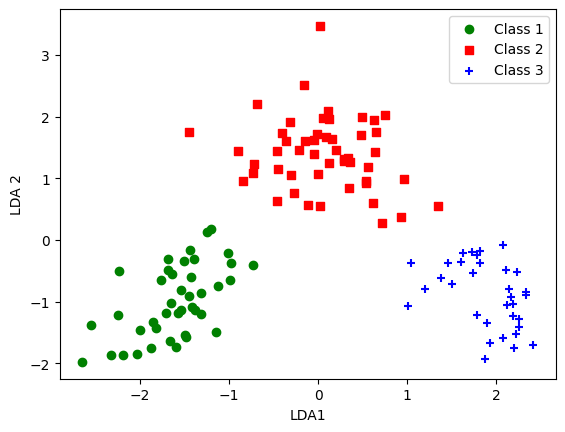

In [7]:
w = np.hstack((eigen_pairs[0][1][:,np.newaxis].real, eigen_pairs[1][1][:,np.newaxis].real))
print(f"Matrux iz{w}")
X_train_lda = x_train_std.dot(w)

colors = ['g','r','b']
markers = ['o','s', '+']
for l,c,m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l,0],X_train_lda[y_train==l, 1] * (-1), c = c, label = f"Class {l}", marker  = m)

plt.xlabel("LDA1")
plt.ylabel("LDA 2")
plt.legend(loc = "best")




# LDA VIA SCIKIT
 and note pca is unsupervised transformer while lda is supervised trasformer and we still need the claffifier i.e knn or logistic regression
For additional info: https://www.geeksforgeeks.org/machine-learning/ml-linear-discriminant-analysis/

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components= 2)

x_train_lda = lda.fit_transform(x_train_std,y_train)

lr = LogisticRegression(multi_class= 'ovr', random_state= 1, solver= 'lbfgs')
lr.fit(x_train_lda,y_train)


c:\Users\Aron\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='ovr', random_state=1)

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

def plot_Decision(x,y,classifire, resolution = 0.02):
    markers = "o","*","s","d"
    colors = ("blue","green","red","yellow")
    cmap = ListedColormap(colors[:len(np.unique(y))]) # Creaye a unique color for each value Y



    x_min, x_max =(x[:,0].min()-1,x[:,0].max() + 1) #Padding
    x1_min,x2_max = (x[:,1].min() - 1, x[:,1].max() + 1)    
    xx1,xx2 = np.meshgrid(np.arange(x_min,x_max,resolution), np.arange(x1_min,x2_max,resolution)) #Np.arreange(start, stop,increment)
    #meshgrid converts from 1D to ND(2)

    lab = classifire.predict(np.array([xx1.ravel(),  xx2.ravel()]).T) # ravel flatens the values , T is transpose
    lab = lab.reshape(xx1.shape) # xx1 have same shape as xx2

    plt.contourf(xx1,xx2,lab, alpha = 0.4, cmap = cmap)
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())

    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = x[y == cl, 0], y = x[y == cl,1 ], color = colors[idx], marker = markers[idx],label = f"class{cl}" ,edgecolor = "black")

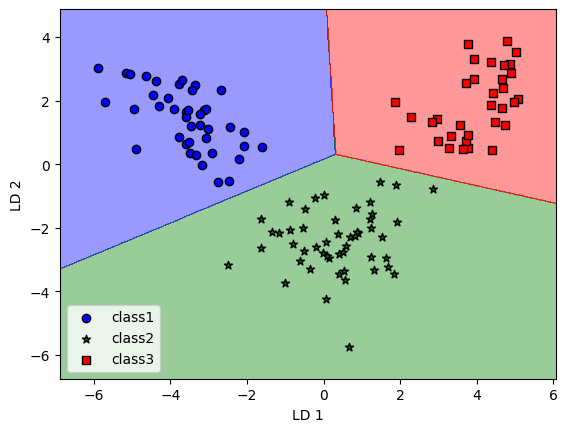

In [11]:
plot_Decision(x_train_lda,y_train, classifire= lr)

plt.xlabel('LD 1')
plt.ylabel('LD 2')

plt.legend(loc = 'best')




0.9814814814814815


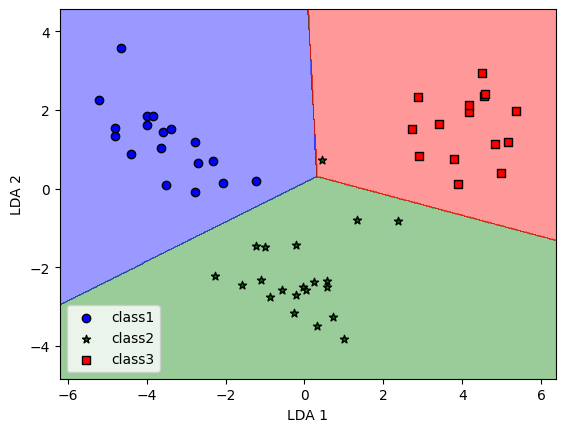

In [15]:
X_test_lda = lda.transform(x_test_std)

plot_Decision(X_test_lda, y_test, classifire= lr)



plt.xlabel('LDA 1')
plt.ylabel('LDA 2')
plt.legend(loc = 'best')

from sklearn.metrics import accuracy_score

y_pred = lr.predict(X_test_lda)
accuracy = accuracy_score(y_pred, y_test)
print(accuracy)
